---
CSC 268 Homework #5: Simple Viola-Jones Face Detection
---

In this homework assignment we will implement a simple version of one of the first commercially successful face recognition algorithms, from the paper by Viola & Jones.  We will not attempt the full learning-based filter cascade they describe, however we will implement the first of their filter layers, which is imperfect yet surprisingly good given its simplicity.

In studying facial detection we should bear in mind that research by Joy Buolamwini and others has shown that many commercial implementations of face detection algorithms exhibit racial bias, in the form of differing performance when applied to subjects of different races.  Buolamwini has called for algorithmic auditing of commercial AI products to ensure that they do not discriminate against specific groups, particularly those who have historically been disadvantaged or marginalized.  In our case we do not plan to employ our face detector for any particular purpose.  Nevertheless it is best to remain aware of potential shortcomings.

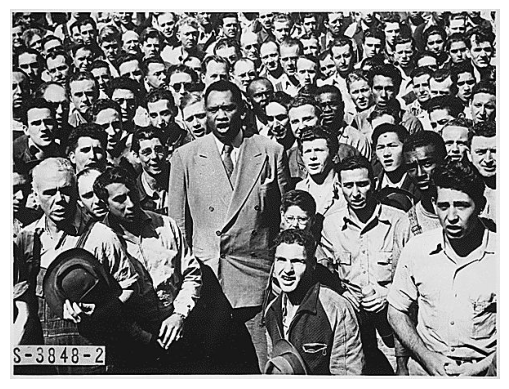

In [2]:
import cv2 as cv
import numpy as np
from scipy.ndimage import label
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rc('image', cmap='gray')

def imshow(img,cmap=None):
    plt.imshow(img)
    plt.axis('off')
    if cmap:
        plt.set_cmap(cmap)
    plt.show()
    
robeson = cv.imread('robeson.jpg',0).astype(np.float32)/255.0
imshow(robeson)



Our detector will only work on faces that are upright and facing the camera.  It will not detect faces in profile or rotated sideways.  We will be able to detect faces at different scales by explicitly searching them.

Recall that the speed of Viola-Jones is based in part on its use of the integral image data structure. Each location in an integral image stores the sum total of the pixel at that location and all pixels to the left and above.

The integral image can be computed quite quickly through two nested calls to NumPy's `cumsum` function. Read the documentation for `cumsum` and figure out how to do this.  Then define a function that will take a grayscale image and return its integral image.

In [3]:
# TODO:  Define a function to return the integral image
def integral_image(img):
  '''returns intergal image, where the sum of all pixels above and to the left of the corresponding pixel in the original image'''
  rows = np.cumsum(img, axis=0)
  cols = np.cumsum(rows, axis=1)
  #stack vertically
  int_img = np.vstack((np.zeros((1, img.shape[1])), cols))
  #stack horizontally 
  #a column vector of zeros with height equal to the number of rows in the image plus one 
  int_img = np.hstack((np.zeros((img.shape[0]+1, 1)), int_img))
  return int_img
# assumes you have already defined integral_image above.
iir = integral_image(robeson)

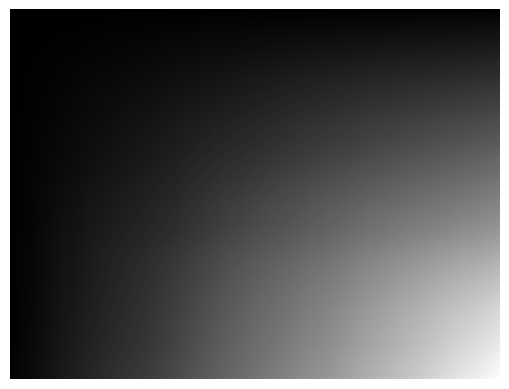

In [4]:
imshow(iir)
#print(iir)

Our primitive face detector will be based upon two basic Haar-like features computed over the entire image. These features are based upon differences computed between the summed pixel values over adjacent rectangular areas. The first feature uses two 4x12 pixel rectangles stacked vertically, light on top of dark. This is intended to detect the forehead and eyes.  The second uses three 4x4 pixel rectangles arranged horizontally, light in the center and dark on either side. This is intended to detect the bridge of the nose between the two eyes.  We will compute each of these features below.

Begin with the 4x12 pixel rectangle sums. Recall that the sum over any rectangular region may be computed with just four references to the integral image. Since we want to evaluate the feature at every possible location in the image, we will combine offset versions of the integral imag. The code below will compute the rectangle sums over all rectangles in the image, starting with the upper left. Then, rectangle sums offset vertically by four pixels are subtracted from each other to get the final filter value.

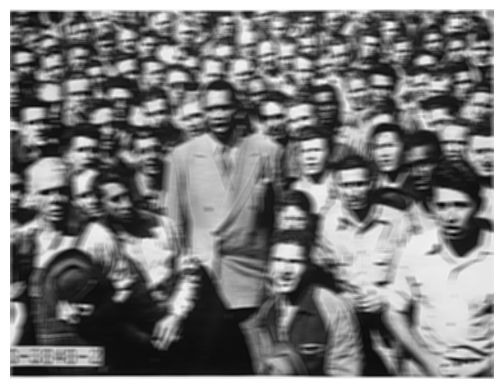

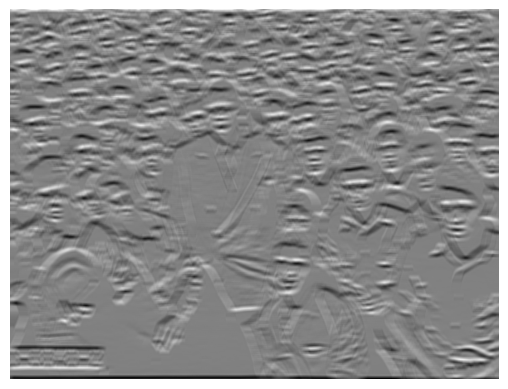

(454, 601) (450, 589) (446, 589)


In [5]:
#intended to detect the forehead and eyes
#vertically light on top of dark
r_4x12 = iir[4:,12:]+iir[:-4,:-12]-iir[4:,:-12]-iir[:-4,12:]  # matrix of 4x12 block sums
#intended to detect the bridge of the nose between the two eyes
#horizontally light in the center and black 
f1 = r_4x12[:-4,:]-r_4x12[4:,:]  # filter is box above minus the box below it
imshow(r_4x12)
imshow(f1)
print(iir.shape, r_4x12.shape, f1.shape)

The resulting feature value map is somewhat smaller than the original image, due to the overlap required to produce its values. Specifically, there are 8 rows and 12 columns missing, because the applying the feature near the edge goes out of bounds. We can add some padding around the borders corresponding to the number of pixels lost, to restore the filtered image to the original size and position the computed filter values in the right place (at the center of the filter area) with respect to the original image. If we threshold the filter response and plot the areas where it is high, you can see that it identifies most of the eyebrow ridges in the photograph.  But there are a lot of other points identified as well.  That is where the second filter comes in.

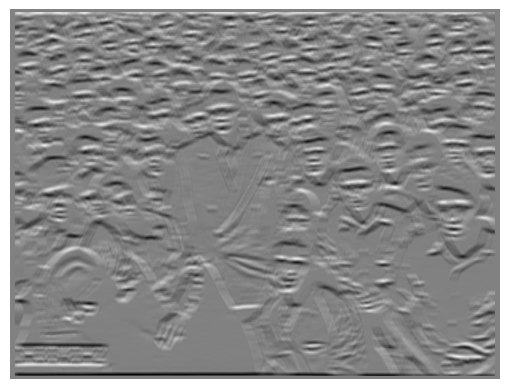

42.623382568359375 19.607843137254903


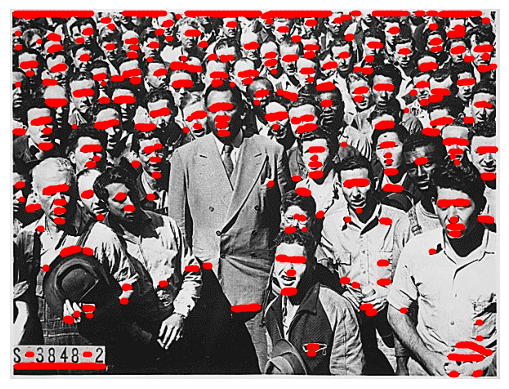

In [6]:
f1p = np.pad(f1,((4,4),(6,6)));
#print(iir.shape,r_4x12.shape,f1.shape,f1p.shape)
imshow(f1p)

plt.figure
plt.imshow(robeson)
print(f1p.max(),5000/255)
y,x = np.nonzero(f1p>20);
plt.plot(x,y,'r.');
plt.axis('off')
plt.show()

def get_f1(img):
  '''applies the 4x12 filter'''
  #calls integral function
  iir = integral_image(img)
  #to compute differnece for padding 
  row, col = iir.shape
  #intended to detect the forehead and eyes
  #vertically light on top of dark
  r_4x12 = iir[4:,12:]+iir[:-4,:-12]-iir[4:,:-12]-iir[:-4,12:]  # matrix of 4x12 block sums
  #intended to detect the bridge of the nose between the two eyes
  #horizontally light in the center and black 
  f1 = r_4x12[:-4,:]-r_4x12[4:,:]  # filter is box above minus the box below it
  row_f, col_f = f1.shape

  #compute differences in shapes
  row_d = (row - row_f) // 2
  col_d = (col - col_f) // 2
  #pad the image to it has the same shape as the original 
  f1 = np.pad(f1, ((row_d, row_d), (col_d, col_d)))
  return f1
# TODO: turn the above into a function that will return the f1 values for any image.

Next you should work on the three side-by-side 4x4 pixel blocks. First compute the block matrix `r_4x4`, then the combined block filter f2. The center block should be positive in weight and counts double; the two blocks flanking it are negative. Again you should pad the filter responses so that they are centered in a result that is the same size as the original image. If you threshold and plot the filter response as before, you will see that it identifies nose bridges among other features. However, close examination reveals that the points identified are somewhat lower on the face than the brow ridges identified by the first filter. So the last step is to shift the second filter response matrix upwards by four pixels. You can do this by removing four rows from the top and adding them to the bottom, or you can use NumPy's `roll` function. 

The final step is to identify points where both filters have a strong response (say greater than 16) and you have a crude but reasonably effective face detector.

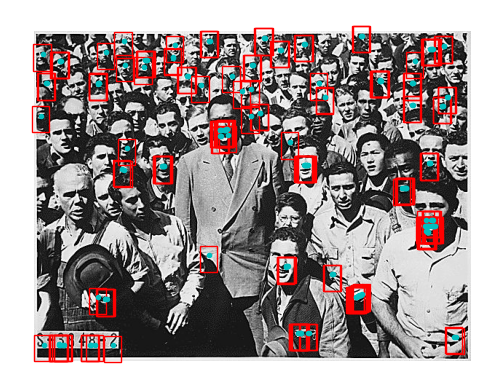

In [15]:
def get_f2(img):
  '''Applies the 4x4 filter'''
  #calls integral function
  iir = integral_image(img)
  #to compute differnece for padding 
  row, col = iir.shape
  #compute block matrix
  r_4x4 = iir[4:,4:]+iir[:-4,:-4]-iir[4:,:-4]-iir[:-4,4:]
  f2=r_4x4[4:-4,4:-4]-r_4x4[:-8,4:-4]-r_4x4[8:,4:-4]
  row_f, col_f = f2.shape
  row_d = (row - row_f) // 2
  col_d = (col - col_f) //2
  f2 = np.pad(f2, ((row_d, row_d), (col_d, col_d)))

  return f2

f2 = get_f2(robeson)

f1 = get_f1(robeson)

def dedectFaces(f1, f2, thershold=4):
  '''Identifies points where both filters have a strong response'''
  y,x = np.nonzero(np.logical_and(f1>thershold, np.roll(f2,-4,0)>thershold))
  return x,y
def showFaces(img,x,y):
    '''Draws approximate boxes around detected face points.'''
    plt.figure
    plt.imshow(img)
    ax = plt.gca()
    for i in range(len(y)):
        r = mpl.patches.Rectangle((x[i]-13,y[i]-13),24,36,edgecolor='r',fill=False)
        ax.add_patch(r)
    plt.plot(x,y,'c.');
    plt.axis('off')
    plt.show()
x,y = dedectFaces(f1, f2, 4)
showFaces(robeson,x,y)

In [13]:
print(f1.shape, f2.shape)

(454, 601) (454, 601)


Notice that the detector above mostly finds faces at a particular scale.  It misses some of the bigger faces.  We 
can scale the image down a bit and and run the detector again.

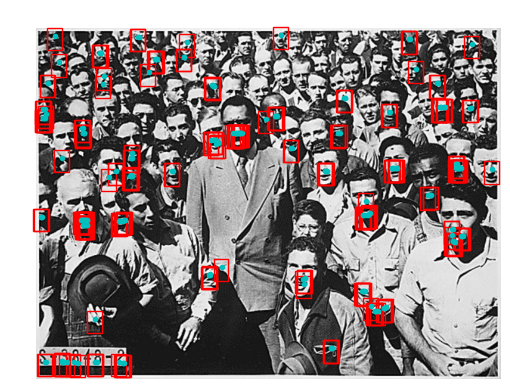

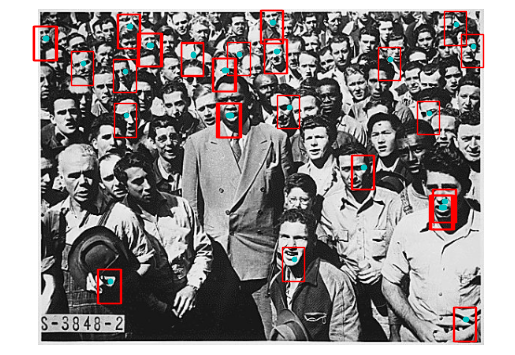

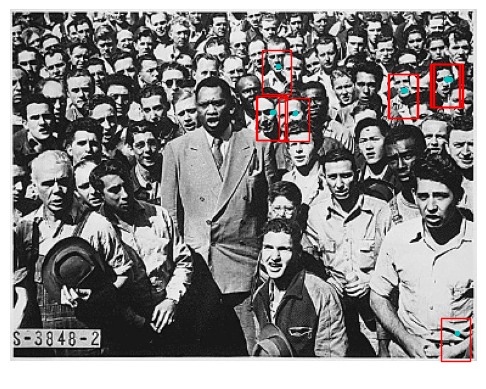

In [16]:
# TODO: write a single function that takes an image and returns the y,x coordinates of the 
# faces detected using the method above.  Call it on the image scaled by different amounts:
# 1.25, 0.8, 0.64, etc. (use cv.resize).
scale_1 = cv.resize(robeson, (int(robeson.shape[1] * 1.25), int(robeson.shape[0] * 1.25)))
f1_1 = get_f1(scale_1)
f2_1 = get_f2(scale_1)
x_1, y_1 = dedectFaces(f1_1, f2_1)
showFaces(scale_1,x_1,y_1)

scale_2 = cv.resize(robeson, (int(robeson.shape[1] * 0.80), int(robeson.shape[0] * 0.80)))
f1_2 = get_f1(scale_2)
f2_2 = get_f2(scale_2)
x_2, y_2 = dedectFaces(f1_2, f2_2)
showFaces(scale_2,x_2,y_2)

scale_3 = cv.resize(robeson, (int(robeson.shape[1] * 0.64), int(robeson.shape[0] * 0.64)))
f1_3 = get_f1(scale_3)
f2_3 = get_f2(scale_3)
x_3, y_3 = dedectFaces(f1_3, f2_3)
showFaces(scale_3,x_3,y_3)

Of course, scaling the image and recomputing the integral image adds computation time.  However, it turns out that it's not necessary -- we can scale the detector instead, and thanks to the integral image it will work just as well.

To complete the detection system, we therefore need to do a few things:
1. Write a general rectangle-sum function that can compute the sums for rectangles of any size
2. Write functions that can compute the f1 and f2 filters, given a scale.  For example, at scale 1.25 the f1 filter will use 5x15 boxes and the f2 filter will use 5x5 boxes.
3. Use the filter computations in a function that takes an image plus scale as input, and returns the y and x for all faces detected at that scale
4. Write one more function that will call the one above in a loop, at different scales separated by multiples of 1.25.  It should return the scale and coordinates for each detection.

Try your function on some other images, including ones of your own.  How well does it work?  You can adjust the threshold values used, if necessary.

In [19]:
# TODO:  Write the functions requested above.

def rect_sum(iir, n, m):
  '''computes the sum for rects of any size'''
  return iir[m:,n:]+iir[:-m,:-n]-iir[m:,:-n]-iir[:-m,n:]


def get_scaled_f1(img, scale):
  '''applies the 4x12 filter to any scale'''
  #computes the box dimensions at the desired scale
  n, m = int(12 * scale), int(4 * scale)

  #calls integral function
  iir = integral_image(img)
  #to compute differnece for padding 
  row, col = iir.shape
  r_4x12 =rect_sum(iir, n, m)# matrix of 4x12 block sums
  f1 = r_4x12[:-m,:]-r_4x12[m:,:]  # filter is box above minus the box below it
  row_f, col_f = f1.shape
  #compute differences in shapes
  row_d = (row - row_f) // 2
  col_d = (col - col_f) // 2
  #pad the image to it has the same shape as the original 
  f1 = np.pad(f1, ((row_d, row_d), (col_d, col_d)))
  return f1


def get_scaled_f2(img, scale):
  '''Applies the 4x4 filter to any scale'''
  #computes the box dimensions at the desired scale
  n, m = int(4 * scale), int(4 * scale)
  #calls integral function
  iir = integral_image(img)
  #to compute differnece for padding 
  row, col = iir.shape
  #compute block matrix
  r_4x4 = rect_sum(iir, n, m)
  f2= iir[4:,4:]+2*iir[:-4,:-4]-iir[:-4,4:]
  row_f, col_f = f2.shape
  row_d = (row - row_f) // 2
  col_d = (col - col_f) //2
  f2 = np.pad(f2, ((row_d, row_d), (col_d, col_d)))
  f2 = np.roll(f2,-4,0)

  return f2


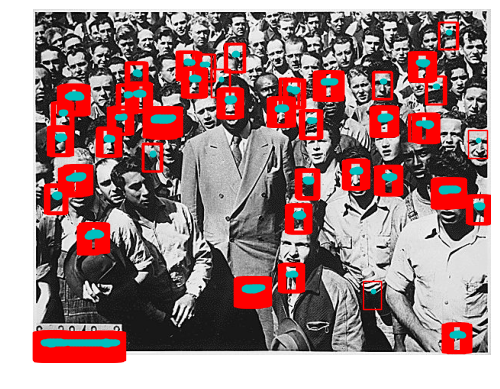

In [24]:
def get_rec(img, scale, thershold=4):
  # Resize the image to the desired scale
  # resized = cv.resize(img, (int(img.shape[1] * scale), int(img.shape[0] * scale)))

  f1 = get_scaled_f1(img, scale)
  f2 = get_scaled_f2(img, scale)
  x,y = dedectFaces(f1, f2, thershold)
  # Scale the coordinates back up to the original image size
  # x = np.round(x / scale).astype(int)
  # y = np.round(y / scale).astype(int)
  
  showFaces(img,x,y)

get_rec(robeson, 2, 80)

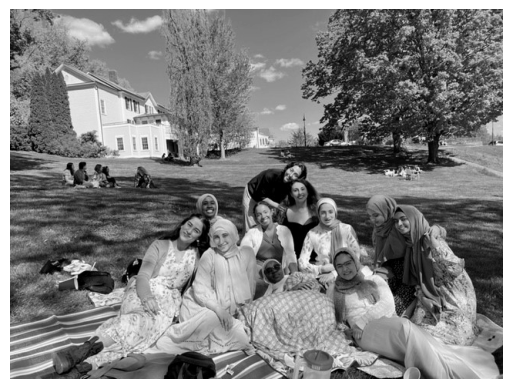

In [42]:
friends = cv.imread('friends.jpg',0).astype(np.float32)/255.0
imshow(friends) 

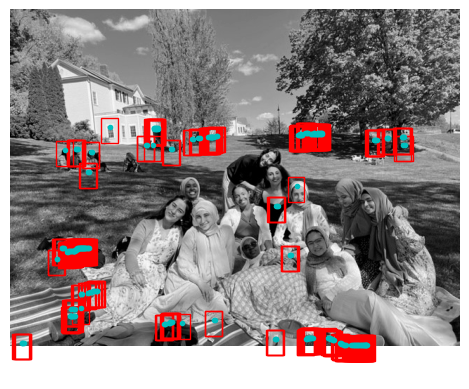

In [45]:
get_rec(friends, 0.50, 5)

Relfection
I dont think the algorithm worked as I hoped. Maybe I did/misunderstood the second method and had issues with the function `getrec`. I also understand where colorism plays a rule in this algorithm since it mostly focuses on the intensities and when they change. Darker skins might have less of a shrap intensity. 